# Similarity Matching

In [3]:
# Load Installation
%run setup.py

In [57]:
df_Invited = pd.read_csv(os.path.join(filepath,'factInvited.csv'))
df_Invited['Source'] = "Invited"

df_Proceedings = pd.read_csv(os.path.join(filepath,'factProceedings.csv'))
df_Proceedings['Source'] = "Proceedings"

# # Append data to one dataframe
df = pd.concat([df_Proceedings,df_Invited], sort=False, axis=0)
df = df[df['Productivity'] != 0].reset_index(drop=True)
df['log(Paper Count)'] = np.log(df['Paper Count'])
df['idx'] = df.index
df.head(3)

,Full name,Year,Conference (short),First name,Middle name,Last name,gender,column_equal,Paper Count,Max Paper Count,First year paper,ID,Age,Conference (long),Main Topic,Productivity,Source,log(Paper Count),idx
0,Aaron Gage,2004,AAAI,Aaron,NaN,Gage,M,True,7,8,1999,Aaron Gage_1,5,AAAI Conference on Artificial Intelligence,Artificial Intelligence,1.400000,Proceedings,1.945910,0
1,Abhi Shelat,2004,AAAI,Abhi,NaN,Shelat,M,True,7,75,2002,Abhi Shelat_1,2,AAAI Conference on Artificial Intelligence,Artificial Intelligence,3.500000,Proceedings,1.945910,1
2,Adele E. Howe,2004,AAAI,Adele,E.,Howe,F,True,48,91,1986,Adele E. Howe_1,18,AAAI Conference on Artificial Intelligence,Artificial Intelligence,2.666667,Proceedings,3.871201,2


## Define Function

In [4]:
def Nearest_Neighbor(df,k,q,n,print_results):
    df_F = df[df['gender'] == 'F'].reset_index(drop=True)
    df_M = df[df['gender'] == 'M']

    nbrs = NearestNeighbors(n_neighbors=k).fit(df_F[['log(Paper Count)','Productivity','Age']])
    distances, indices = nbrs.kneighbors(df_M[['log(Paper Count)','Productivity','Age']])
    
    # Find threshold
    threshold = np.quantile(distances.flatten(),q=q)
    mask = distances <= threshold
    if print_results == True:
        print('Threshold',threshold)
        print('Pct. of indices I keep',mask.flatten()[mask.flatten() == True].shape[0] / mask.flatten().shape[0])

    filtered_indices = indices.copy().astype(float)
    filtered_indices[~mask] = np.nan
    
    # Initiliaze ratio list
    ratio_list = []
    
    for i in range(0,n):
        results = df_M.copy()
        results['Similar idx'] = [random.choice(row) for row in indices.tolist()] # select index
        results = results.dropna(subset=['Similar idx'])
        results = results.merge(right = df_F, left_on='Similar idx', right_index=True, how='left',suffixes=['_M','_F']) # merge info
        
        P_males_inv = results['Source_M'].value_counts(normalize=True).loc['Invited']
        P_females_inv = results['Source_F'].value_counts(normalize=True).loc['Invited']
        ratio = np.divide(P_females_inv,P_males_inv)
        ratio_list.append(ratio)
    
    mean_ratio = np.mean(ratio_list)
    std_ratio = np.std(ratio_list)
    
    return mean_ratio, std_ratio

In [54]:
def Nearest_Neighbor(df,k,q,n,print_results):
    df_F = df[df['gender'] == 'F'].reset_index(drop=True)
    df_M = df[df['gender'] == 'M']

    nbrs = NearestNeighbors(n_neighbors=k).fit(df_F[['log(Paper Count)','Productivity','Age']])
    distances, indices = nbrs.kneighbors(df_M[['log(Paper Count)','Productivity','Age']])
    
    # Find threshold
    threshold = np.quantile(distances.flatten(),q=q)
    mask = distances <= threshold
    if print_results == True:
        print('Threshold',threshold)
        print('Pct. of indices I keep',mask.flatten()[mask.flatten() == True].shape[0] / mask.flatten().shape[0])

    filtered_indices = indices.copy().astype(float)
    filtered_indices[~mask] = np.nan
    
    # Initiliaze ratio list
    ratio_list = []
    
    for i in range(0,n):
        results = df_M.copy()
        results['Similar idx'] = [random.choice(row) for row in filtered_indices.tolist()] # select index
        results = results.dropna(subset=['Similar idx'])
        results = results.merge(right = df_F, left_on='Similar idx', right_index=True, how='left',suffixes=['_M','_F']) # merge info
        
        P_males_inv = results['Source_M'].value_counts(normalize=True).loc['Invited']
        P_females_inv = results['Source_F'].value_counts(normalize=True).loc['Invited']
        ratio = np.divide(P_females_inv,P_males_inv)
        ratio_list.append(ratio)
    
    mean_ratio = np.mean(ratio_list)
    std_ratio = np.std(ratio_list)
    
    return mean_ratio, std_ratio

## Plot Nearest Neighbor with 1,5 and 10 neighbors

100%|██████████| 20/20 [04:29<00:00, 13.46s/it]


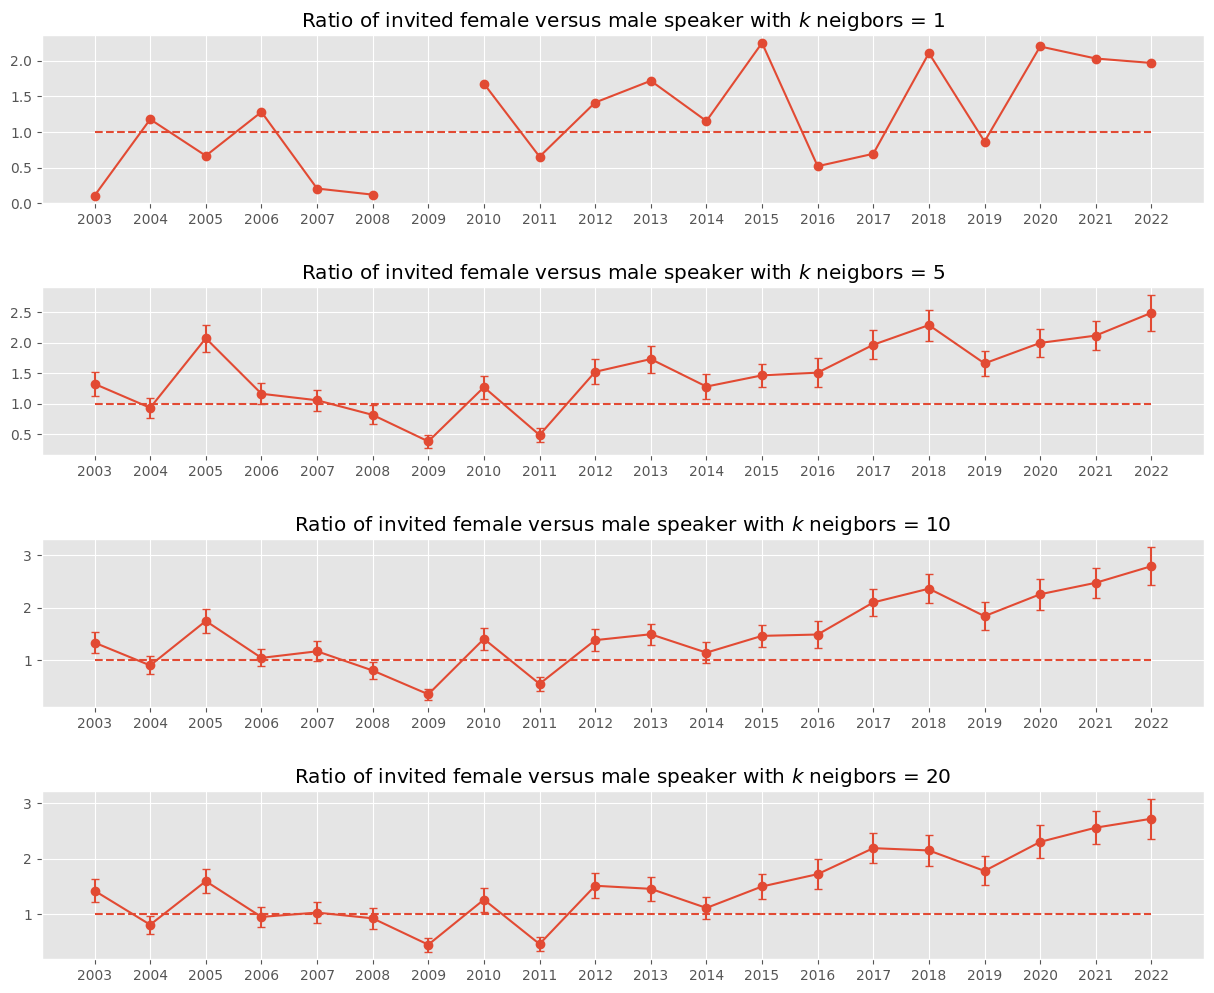

In [55]:
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
k_list = [1,5,10,20]

for n, k in enumerate(k_list):
    ax = plt.subplot(len(k_list), 1, n + 1)
    # ax.plot(df['Age'],'o',alpha=0.1)
    
    ratio_list = []
    std_list = []
    for year in tqdm(range(2003,2023)):
        try:
            df_year = df[df['Year'] == year]
            mean_ratio, std_ratio = Nearest_Neighbor(df_year,k=k, q=0.9, n=1000, print_results=False)
            ratio_list.append(mean_ratio)
            std_list.append(std_ratio)
        except: 
            ratio_list.append(np.NaN)
            std_list.append(np.NaN)
            continue
        
    ax.errorbar(range(2003,2023), ratio_list, yerr=std_list, fmt='o-', capsize=3,label="Adj. Ratio")
    ax.set_title('Ratio of invited female versus male speaker with $k$ neigbors = ' + str(k))
    ax.set_xticks(range(2003,2023,1))
    ax.hlines(1, 2003, 2022, linestyles='dashed')
    

## Heatmap

In [58]:
def map_age_group(age_range):
    if age_range >=  20:
        return '>20'
    elif age_range >= 15:
        return '15-20'
    elif age_range >= 10:
        return '10-15'
    elif age_range >= 5:
        return '5-10'
    else:
        return '0-5'
    
df['Age Group'] = df['Age'].apply(map_age_group)

In [59]:
df.head()

,Full name,Year,Conference (short),First name,Middle name,Last name,gender,column_equal,Paper Count,Max Paper Count,First year paper,ID,Age,Conference (long),Main Topic,Productivity,Source,log(Paper Count),idx,Age Group
0,Aaron Gage,2004,AAAI,Aaron,NaN,Gage,M,True,7,8,1999,Aaron Gage_1,5,AAAI Conference on Artificial Intelligence,Artificial Intelligence,1.400000,Proceedings,1.945910,0,5-10
1,Abhi Shelat,2004,AAAI,Abhi,NaN,Shelat,M,True,7,75,2002,Abhi Shelat_1,2,AAAI Conference on Artificial Intelligence,Artificial Intelligence,3.500000,Proceedings,1.945910,1,0-5
2,Adele E. Howe,2004,AAAI,Adele,E.,Howe,F,True,48,91,1986,Adele E. Howe_1,18,AAAI Conference on Artificial Intelligence,Artificial Intelligence,2.666667,Proceedings,3.871201,2,15-20
3,Akihiro Kishimoto,2004,AAAI,Akihiro,NaN,Kishimoto,M,True,4,62,2002,Akihiro Kishimoto_1,2,AAAI Conference on Artificial Intelligence,Artificial Intelligence,2.000000,Proceedings,1.386294,3,0-5
4,Al Globus,2004,AAAI,Al,NaN,Globus,M,True,6,6,1990,Al Globus_1,14,AAAI Conference on Artificial Intelligence,Artificial Intelligence,0.428571,Proceedings,1.791759,4,10-15


In [62]:
ratio_list = []
std_list = []
for age in tqdm(df['Age Group'].unique()): 
    try:
        df_year = df[df['Age Group'] == age]
        mean_ratio, std_ratio = Nearest_Neighbor(df_year,k=10, q=0.1, n=1000, print_results=False)
        ratio_list.append(mean_ratio)
        std_list.append(std_ratio)
    except: 
        ratio_list.append(np.NaN)
        std_list.append(np.NaN)
        continue
# ratio_list = np.array(ratio_list).reshape(20,5)
ratio_list

[nan, nan, 1.1691604437957817, nan, 1.3069306702516559]

<AxesSubplot: xlabel='index'>

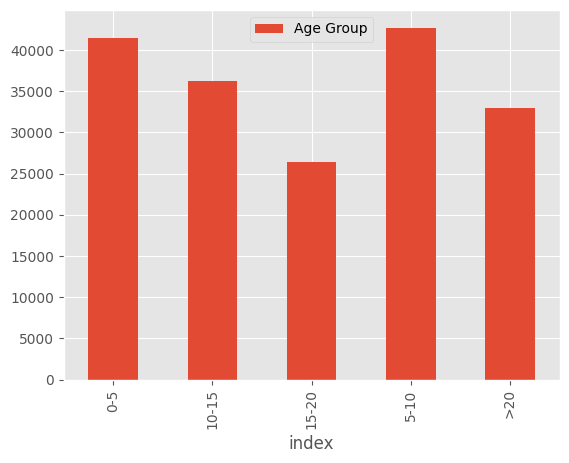

In [65]:
df['Age Group'].value_counts().reset_index().sort_values(by='index').plot.bar(x='index',y='Age Group')

In [29]:
ratio_list = np.array(ratio_list).reshape(20,5)

In [30]:
ratio_list

array([[nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan]])

In [46]:
df1 = df[(df['Year'] == 2020) & (df['Age Group'] == '10-15')]
df_F = df1[df1['gender'] == 'F'].reset_index(drop=True)
df_M = df1[df1['gender'] == 'M']

nbrs = NearestNeighbors(n_neighbors=5).fit(df_F[['log(Paper Count)','Productivity','Age']])
distances, indices = nbrs.kneighbors(df_M[['log(Paper Count)','Productivity','Age']])

# Find threshold
threshold = np.quantile(distances.flatten(),q=0.9)
mask = distances <= threshold
# if print_results == True:
#     print('Threshold',threshold)
#     print('Pct. of indices I keep',mask.flatten()[mask.flatten() == True].shape[0] / mask.flatten().shape[0])
filtered_indices = indices.copy().astype(float)
filtered_indices[~mask] = np.nan

# Initiliaze ratio list
ratio_list = []

In [53]:
indices

array([[ 76,  75, 806, 391, 381],
       [ 76,  75, 806, 391, 381],
       [664, 665, 816, 484, 366],
       ...,
       [180, 617, 440, 409, 770],
       [225, 611, 232, 231, 494],
       [ 20,  21, 244,  77,  78]], dtype=int64)

In [51]:
results = df_M.copy()
results['Similar idx'] = [random.choice(row) for row in indices.tolist()] # select index
results = results.dropna(subset=['Similar idx'])
results = results.merge(right = df_F, left_on='Similar idx', right_index=True, how='left',suffixes=['_M','_F']) # merge info

In [52]:
results['Source_M'].value_counts(normalize=True)

Proceedings    0.998791
Invited        0.001209
Name: Source_M, dtype: float64

In [ ]:
results['Source_M'].value_counts(normalize=True).loc['Invited']

In [ ]:
P_males_inv = results['Source_M'].value_counts(normalize=True).loc['Invited']
P_females_inv = results['Source_F'].value_counts(normalize=True).loc['Invited']
ratio = np.divide(P_females_inv,P_males_inv)
ratio_list.append(ratio)
